In [7]:
%load_ext autoreload
%autoreload 2
%pylab inline

import pandas as pd
from scipy.spatial.distance import cdist
import seaborn as sns
from sklearn.base import clone
from sklearn.datasets import make_circles
from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ClassificationReport, ROCAUC, ConfusionMatrix, DecisionBoundariesVisualizer

from BEKML import BEMKL, poly_kernel, gauss_kernel, scoring


def plot_decision_boundaries(model, X, y, ax=None):
    if ax is None:
        ax = plt.figure(figsize=(8, 8)).gca()
    dv = DecisionBoundariesVisualizer(model, classes=[-1, 1],
                                      ax=ax, step_size=0.025, show_scatter=False)
    markers = next(dv.markers), next(dv.markers)
    ax.scatter(*X[y==-1].T, color=dv.colors[0], edgecolors='black', marker=markers[0], s=30)
    ax.scatter(*X[y==1].T, color=dv.colors[1], edgecolors='black', marker=markers[1], s=30)
    dv.fit_draw_poof(X, y)

    
def evaluate_model(model, X, y):
    X_train, X_test, y_train, y_test =\
        train_test_split(X, y, test_size=0.2, stratify=y)

    model.fit(X_train, y_train)
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    cr = ClassificationReport(model, classes=[-1, 1], ax=ax)
    cr.fit(X_train, y_train)
    cr.score(X_test, y_test)
    cr.poof()

    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    cm = ConfusionMatrix(model, classes=[-1, 1], ax=ax)
    cm.fit(X_train, y_train)
    cm.score(X_test, y_test)
    cm.poof()
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    rocauc = ROCAUC(model, classes=[-1, 1], ax=ax)
    rocauc.fit(X_train, y_train)
    rocauc.score(X_test, y_test)
    rocauc.poof()
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    plot_decision_boundaries(model, X, y, ax=ax)
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    model.plot_e(rug=True, kde=True, norm_hist=True, ax=ax,
                 rug_kws={'color': 'g', 'linewidth': 4})
    
    model_cv = clone(model)
    scoring.iteration = 0
    folds = RepeatedStratifiedKFold(n_splits=3, n_repeats=2)
    return cross_validate(model_cv, X, y, cv=folds, scoring=scoring)


sns.set(style='ticks', context='talk')
np.set_printoptions(precision=4, linewidth=100)
N = 1000
D = 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [2]:
kernels = [lambda A, B: gauss_kernel(A, B, 2**i) for i in range(-3, 7)]
kernels += [lambda A, B: poly_kernel(A, B, 0, i) for i in range(1, 4)]
kernels += [lambda A, B: gauss_kernel(A[:, j:j+1], B[:, j:j+1], 2**i) for i in range(-3, 7) for j in range(D)]
kernels += [lambda A, B: poly_kernel(A[:, j:j+1], B[:, j:j+1], 0, i) for i in range(1, 4) for j in range(D)]
len(kernels)

39

# Clean Data

,x1,x2,y
0,0.740062,-0.303823,1
1,0.532809,-0.596753,1
2,0.750987,-0.275714,1
3,-0.481754,0.876307,-1
4,0.745941,-0.666012,-1


,x1,x2,y
count,1.000000e+03,1.000000e+03,1000.0000
mean,9.325873e-18,2.498002e-17,0.0000
std,6.406328e-01,6.406328e-01,1.0005
min,-1.000000e+00,-1.000000e+00,-1.0000
25%,-6.240002e-01,-6.240002e-01,-1.0000
50%,-4.898587e-17,4.898587e-17,0.0000
75%,6.240002e-01,6.240002e-01,1.0000
max,1.000000e+00,1.000000e+00,1.0000


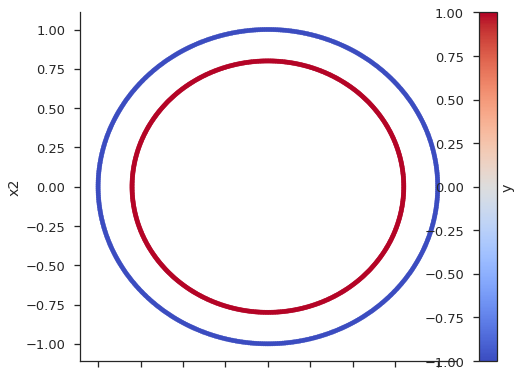

In [3]:
X, y = make_circles(N)
data = pd.DataFrame(X, columns=['x1', 'x2'])
y[y == 0] = -1
data['y'] = y

display(data.head())
display(data.describe())
data.plot.scatter('x1', 'x2', c='y', cmap='coolwarm')
sns.despine()
plt.tight_layout()

## Sparse Model

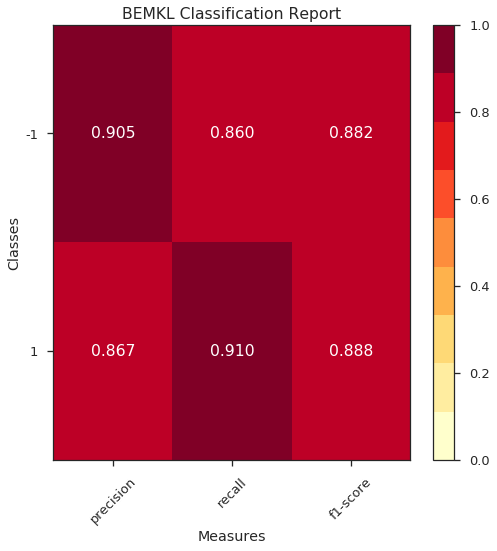

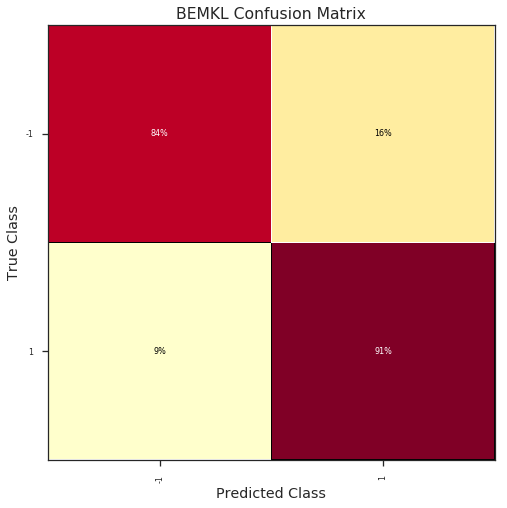

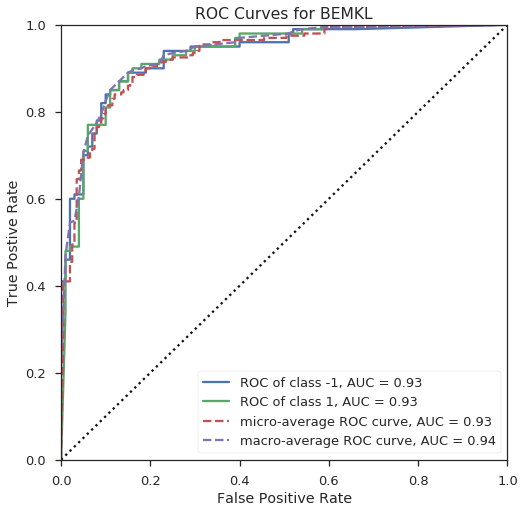

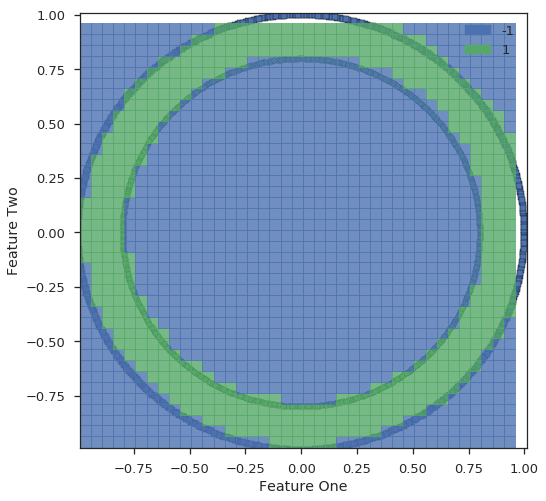

0 - Non-0: 30. Total: 39. Ratio: 0.7692307692307693. Mean e: 0.1477. Median e: 0.2010. Std e: 0.0817. 
1 - Non-0: 30. Total: 39. Ratio: 0.7692307692307693. Mean e: 0.1464. Median e: 0.2045. Std e: 0.0821. 
2 - Non-0: 30. Total: 39. Ratio: 0.7692307692307693. Mean e: 0.1537. Median e: 0.2360. Std e: 0.0954. 
3 - Non-0: 30. Total: 39. Ratio: 0.7692307692307693. Mean e: 0.1385. Median e: 0.1924. Std e: 0.0774. 
4 - Non-0: 30. Total: 39. Ratio: 0.7692307692307693. Mean e: 0.1364. Median e: 0.1758. Std e: 0.0747. 
5 - Non-0: 30. Total: 39. Ratio: 0.7692307692307693. Mean e: 0.1489. Median e: 0.2070. Std e: 0.0832. 


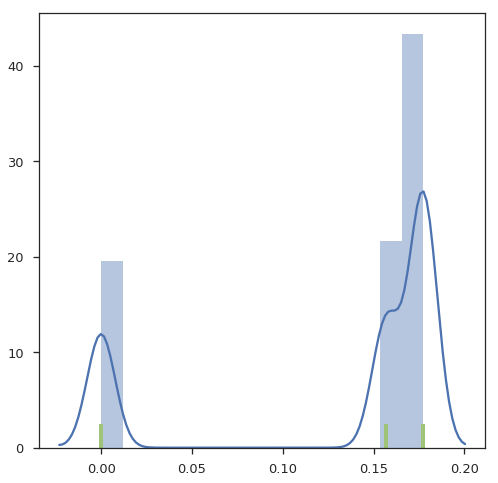

In [8]:
sparse_model = BEMKL(kernels=kernels, alpha_lambda=1, beta_lambda=1, alpha_gamma=1,
                     beta_gamma=1, alpha_omega=1e-11, beta_omega=1e+9,
                     null_threshold=1e-3)
evaluate_model(sparse_model, X, y)

## Non-Sparse Model

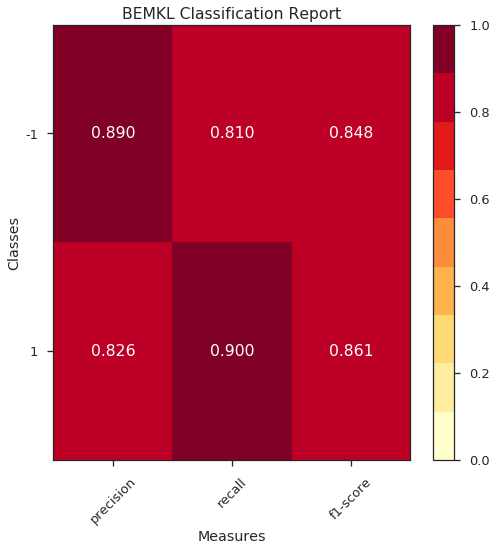

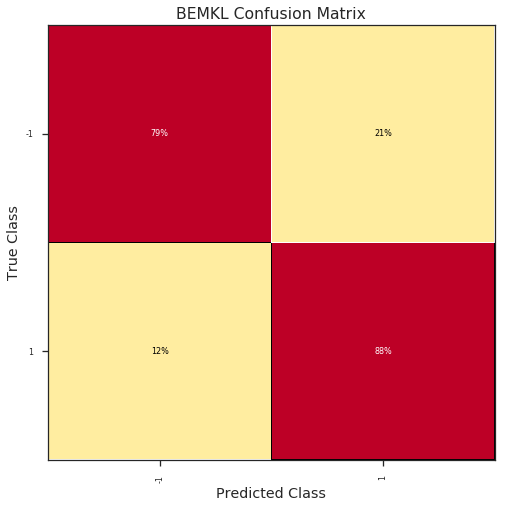

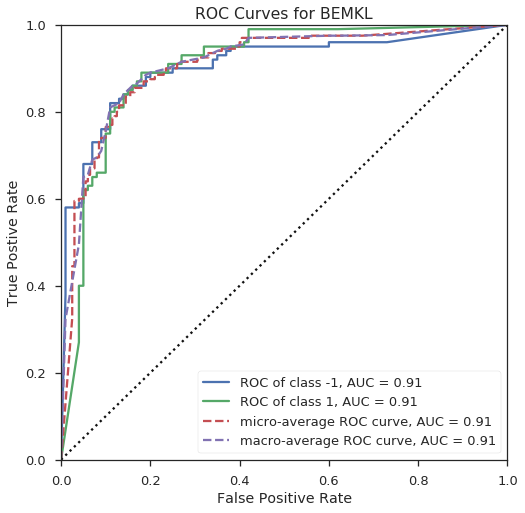

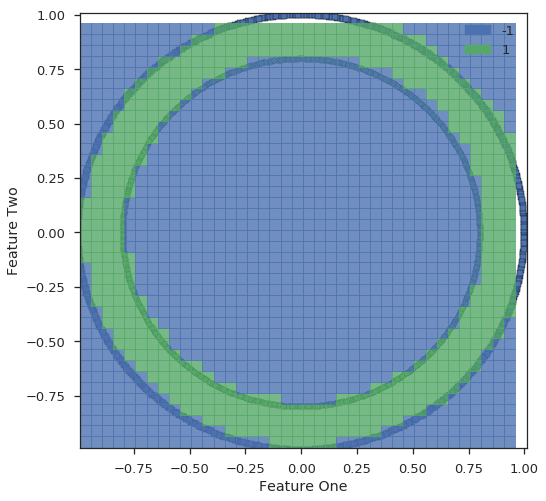

0 - Non-0: 39. Total: 39. Ratio: 1.0. Mean e: 0.1460. Median e: 0.2047. Std e: 0.0893. 
1 - Non-0: 39. Total: 39. Ratio: 1.0. Mean e: 0.1761. Median e: 0.2117. Std e: 0.0509. 
2 - Non-0: 36. Total: 39. Ratio: 0.9230769230769231. Mean e: 0.1719. Median e: 0.1834. Std e: 0.0553. 
3 - Non-0: 39. Total: 39. Ratio: 1.0. Mean e: 0.1921. Median e: 0.2310. Std e: 0.0431. 
4 - Non-0: 36. Total: 39. Ratio: 0.9230769230769231. Mean e: 0.1520. Median e: 0.2027. Std e: 0.0649. 
5 - Non-0: 33. Total: 39. Ratio: 0.8461538461538461. Mean e: 0.1479. Median e: 0.1932. Std e: 0.0705. 


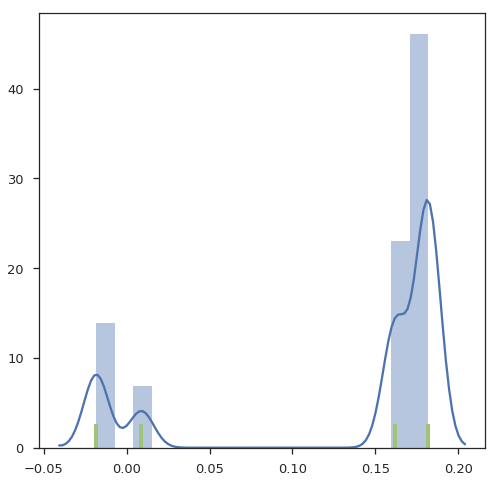

In [9]:
normal_model = BEMKL(kernels=kernels, alpha_lambda=1, beta_lambda=1, alpha_gamma=1,
                     beta_gamma=1, alpha_omega=1, beta_omega=1, null_threshold=1e-3)
evaluate_model(normal_model, X, y)

# Noisy Data

,x1,x2,y
0,0.827544,-0.067885,-1
1,0.689854,-0.025035,1
2,1.150849,-0.181037,-1
3,1.155529,0.824969,-1
4,0.764254,-0.513838,-1


,x1,x2,y
count,1000.000000,1000.000000,1000.0000
mean,-0.002946,-0.005419,0.0000
std,0.555208,0.556109,1.0005
min,-1.433280,-1.474428,-1.0000
25%,-0.364152,-0.361852,-1.0000
50%,-0.012370,-0.011200,0.0000
75%,0.356331,0.368449,1.0000
max,1.366866,1.753464,1.0000


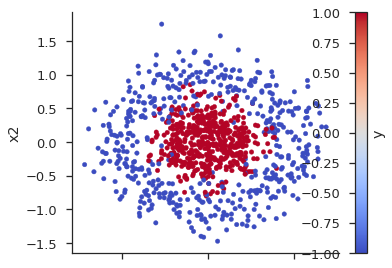

In [11]:
X, y = make_circles(N, noise=0.2, factor=0.3)
data = pd.DataFrame(X, columns=['x1', 'x2'])
y[y == 0] = -1
data['y'] = y
display(data.head())
display(data.describe())
data.plot.scatter('x1', 'x2', c='y', cmap='coolwarm')
sns.despine()
plt.tight_layout()

## Sparse Model

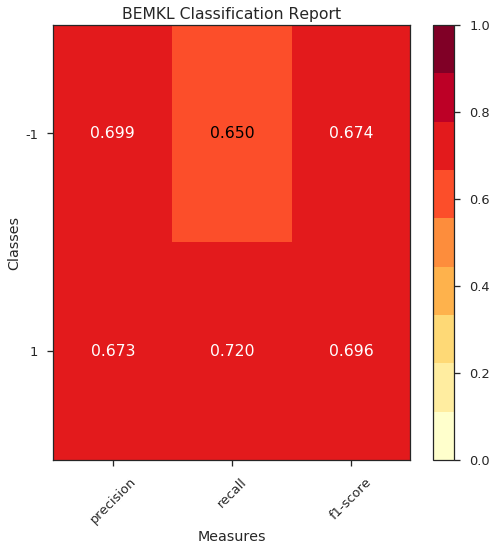

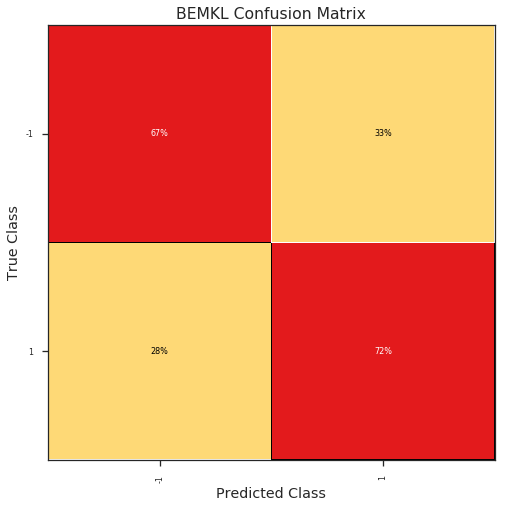

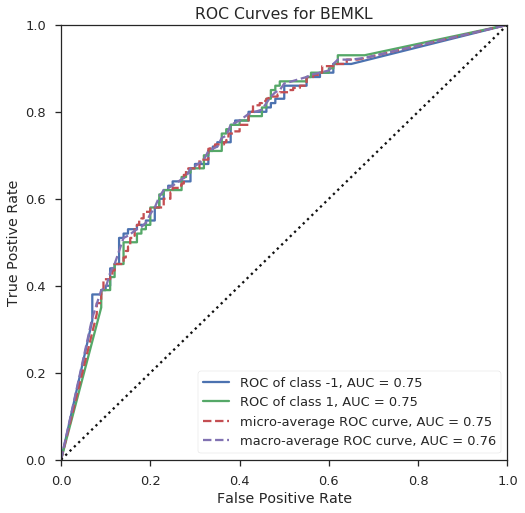

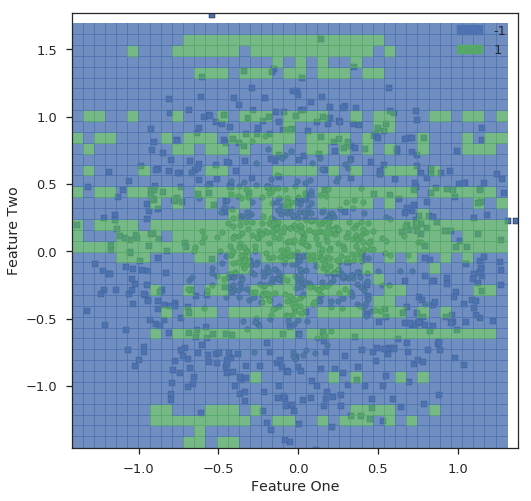

0 - Non-0: 30. Total: 39. Ratio: 0.7692307692307693. Mean e: 0.1345. Median e: 0.1972. Std e: 0.0787. 
1 - Non-0: 30. Total: 39. Ratio: 0.7692307692307693. Mean e: 0.1491. Median e: 0.2324. Std e: 0.0947. 
2 - Non-0: 30. Total: 39. Ratio: 0.7692307692307693. Mean e: 0.1358. Median e: 0.1896. Std e: 0.0761. 
3 - Non-0: 30. Total: 39. Ratio: 0.7692307692307693. Mean e: 0.1386. Median e: 0.1989. Std e: 0.0794. 
4 - Non-0: 30. Total: 39. Ratio: 0.7692307692307693. Mean e: 0.1401. Median e: 0.2053. Std e: 0.0820. 
5 - Non-0: 30. Total: 39. Ratio: 0.7692307692307693. Mean e: 0.1454. Median e: 0.2042. Std e: 0.0818. 


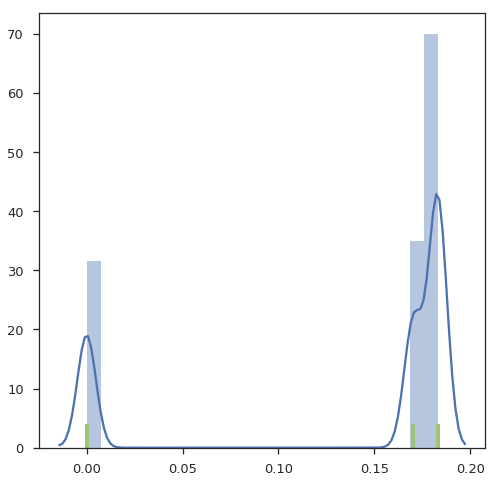

In [12]:
sparse_model = BEMKL(kernels=kernels, alpha_lambda=1, beta_lambda=1, alpha_gamma=1,
                     beta_gamma=1, alpha_omega=1e-11, beta_omega=1e+9, null_threshold=1e-3)
evaluate_model(sparse_model, X, y)

## Non-Sparse Model

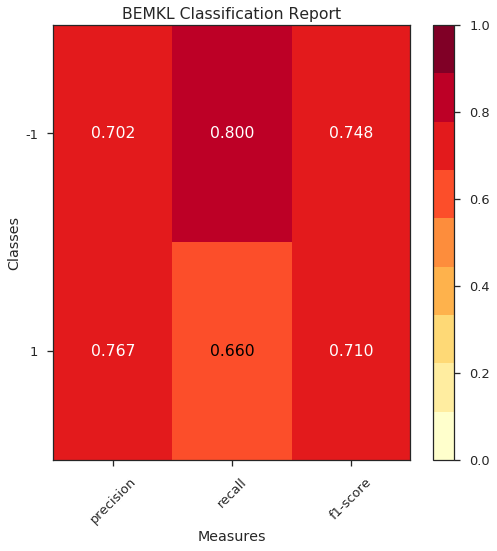

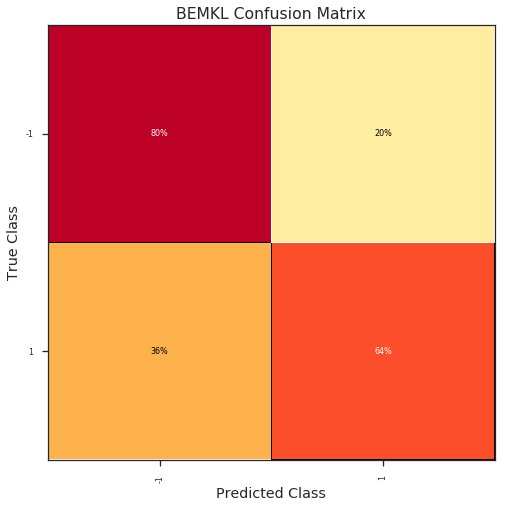

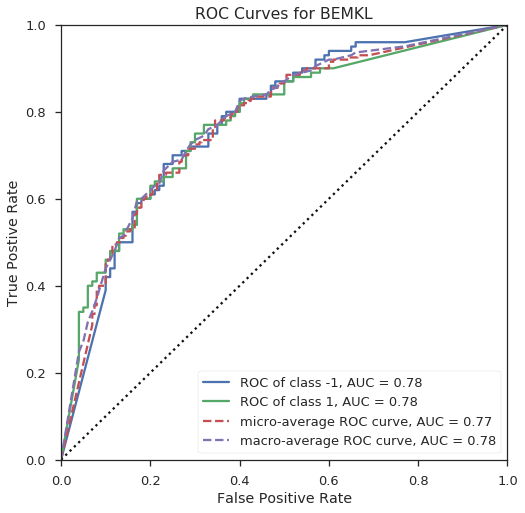

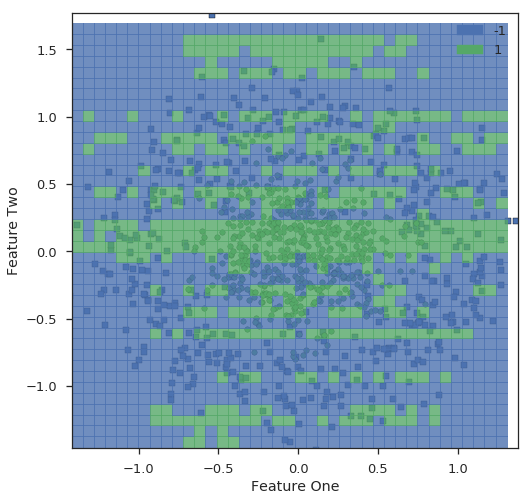

0 - Non-0: 33. Total: 39. Ratio: 0.8461538461538461. Mean e: 0.1454. Median e: 0.2011. Std e: 0.0848. 
1 - Non-0: 36. Total: 39. Ratio: 0.9230769230769231. Mean e: 0.1457. Median e: 0.2151. Std e: 0.0890. 
2 - Non-0: 39. Total: 39. Ratio: 1.0. Mean e: 0.1539. Median e: 0.2014. Std e: 0.0718. 
3 - Non-0: 39. Total: 39. Ratio: 1.0. Mean e: 0.1538. Median e: 0.2053. Std e: 0.0667. 
4 - Non-0: 39. Total: 39. Ratio: 1.0. Mean e: 0.1474. Median e: 0.1859. Std e: 0.0672. 
5 - Non-0: 39. Total: 39. Ratio: 1.0. Mean e: 0.1624. Median e: 0.2284. Std e: 0.0888. 


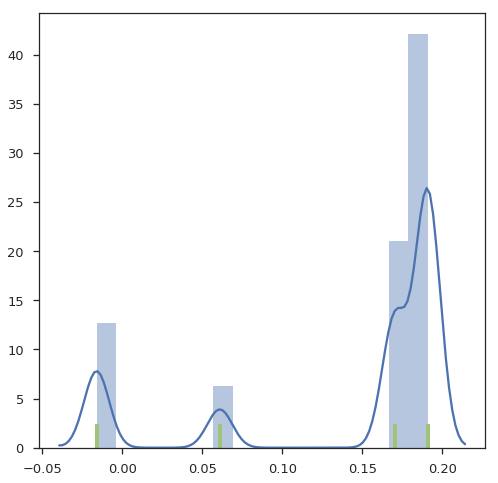

In [13]:
normal_model = BEMKL(kernels=kernels, alpha_lambda=1, beta_lambda=1, alpha_gamma=1,
                     beta_gamma=1, alpha_omega=1, beta_omega=1, null_threshold=1e-3)
evaluate_model(normal_model, X, y)